In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
# Configuration
mu = 0
f0 = 2.4e9
ecp = False
N_size_grid = 1

In [104]:
# Helpers
def plt_complex(cnums, size=1.5):
    X = [x.real for x in cnums]
    Y = [x.imag for x in cnums]
    plt.scatter(X,Y, color='red')
    axes = plt.gca()
    axes.set_xlim([-size, size])
    axes.set_ylim([-size, size])

def plt_complex_grid(a, fig):
    sb_r = len(a)
    sb_c = len(a[0])
    sb_id = 0
    grid = gridspec.GridSpec(sb_r, sb_c, wspace=0.0, hspace=0.0)
    for k in range(sb_r-1,-1,-1):
        size=1.5
        for l in range(sb_c):
            fig.add_subplot(grid[sb_id])
            sb_id += 1;
            plt_complex([a[k, l]], size)
            axes = plt.gca()
            if k != 0:
                axes.set_xticks([])
            else:
                plt.xlabel('l = {}'.format(l))
                axes.set_xticks([-1,0,1])
            if l != 0:
                axes.set_yticks([])
            else:
                plt.ylabel('k = {}'.format(k))
                axes.set_yticks([-1,0,1])
            plt.plot([0, 0], [-size, size], 'k:', lw=1)
            plt.plot([-size, size], [0, 0], 'k:', lw=1)

In [5]:
# 5g constances
N_f=4096
Df_max=480e3
T_c=1/(N_f*Df_max)
kappa=64
Df_ref=15e3
N_f_ref=2048
T_s=1/(Df_ref*N_f_ref)
N_SC_RB=12

In [6]:
if ecp:
    N_slot_symbol = 12
else:
    N_slot_symbol = 14
N_subframe_slot = 2**mu

In [7]:
N_mu_u=2048*kappa/(2**mu)

In [8]:
def N_cp(mu, l, ecp=False):
    if ecp:
        return 512*kappa/2**mu
    elif (l == 0) or (l == 7*2**mu):
        return 144*kappa/2**mu+16*kappa
    else:
        return 144*kappa/2**mu

In [9]:
# Start of symbols in subframe
t_start_l = np.zeros(N_slot_symbol*N_subframe_slot)
for l in range(1, N_slot_symbol*N_subframe_slot):
    t_start_l[l] = t_start_l[l-1] + (N_mu_u + N_cp(mu, l-1, ecp))*T_c

In [10]:
# Modulation
def bpsk(b):
    return 1/np.sqrt(2)*((1-2*b[0])+1j*(1-2*b[0]))

def qpsk(b):
    return 1/np.sqrt(2)*((1-2*b[0]) + 1j*(1-2*b[1]))

def qam16(b):
    re = (1-2*b[0])*(1+2*b[2])
    im = (1-2*b[1])*(1+2*b[3])
    return 1/np.sqrt(10)*(re+1j*im)

def qam64(b):
    re = (1-2*b[0])*(3+2*b[2]-2*b[4]+4*b[2]*b[4])
    im = (1-2*b[1])*(3+2*b[3]-2*b[5]+4*b[3]*b[5])
    return 1/np.sqrt(42)*(re+1j*im)

def qam256(b):
    re = (1-2*b[0])*(8-(1-2*b[2])*(4-(1-2*b[4])*(2-(1-2*b[6]))))
    im = (1-2*b[1])*(8-(1-2*b[3])*(4-(1-2*b[5])*(2-(1-2*b[7]))))
    return 1/np.sqrt(170)*(re+1j*im)

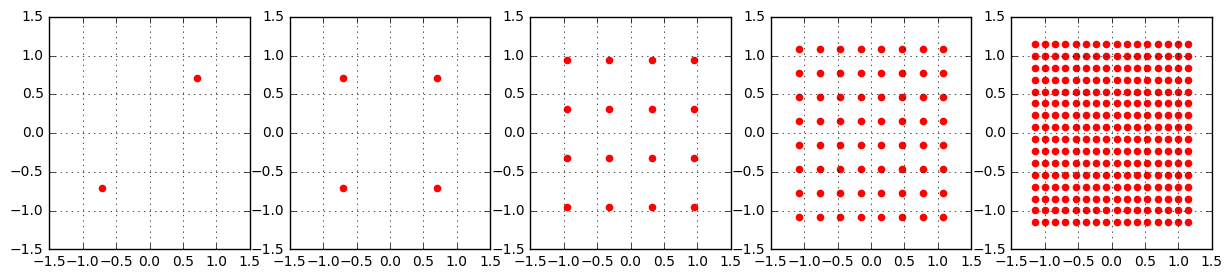

In [105]:
def 
plt.figure(figsize=(15, 3))
sb_id = 151
for modulation, r in zip([bpsk, qpsk, qam16, qam64, qam256],[1,2,4,6,8]):
    q = []
    for b in range(2**r):
        a = np.unpackbits(np.array([b], dtype=np.uint8))        
        q.append(modulation(a[8-r:]))
    plt.subplot(sb_id)
    sb_id += 1
    plt_complex(q)
    plt.grid(True)
plt.show()

In [107]:
a = np.zeros((N_size_grid*N_SC_RB, N_slot_symbol*N_subframe_slot), dtype=np.complex_)
for k in range(N_size_grid*N_SC_RB):
    for l in range(N_slot_symbol*N_subframe_slot):
        v = np.unpackbits(np.array([(k*N_slot_symbol*N_subframe_slot+l)%16], dtype=np.uint8))
        a[k,l] = qam16(v[4:])

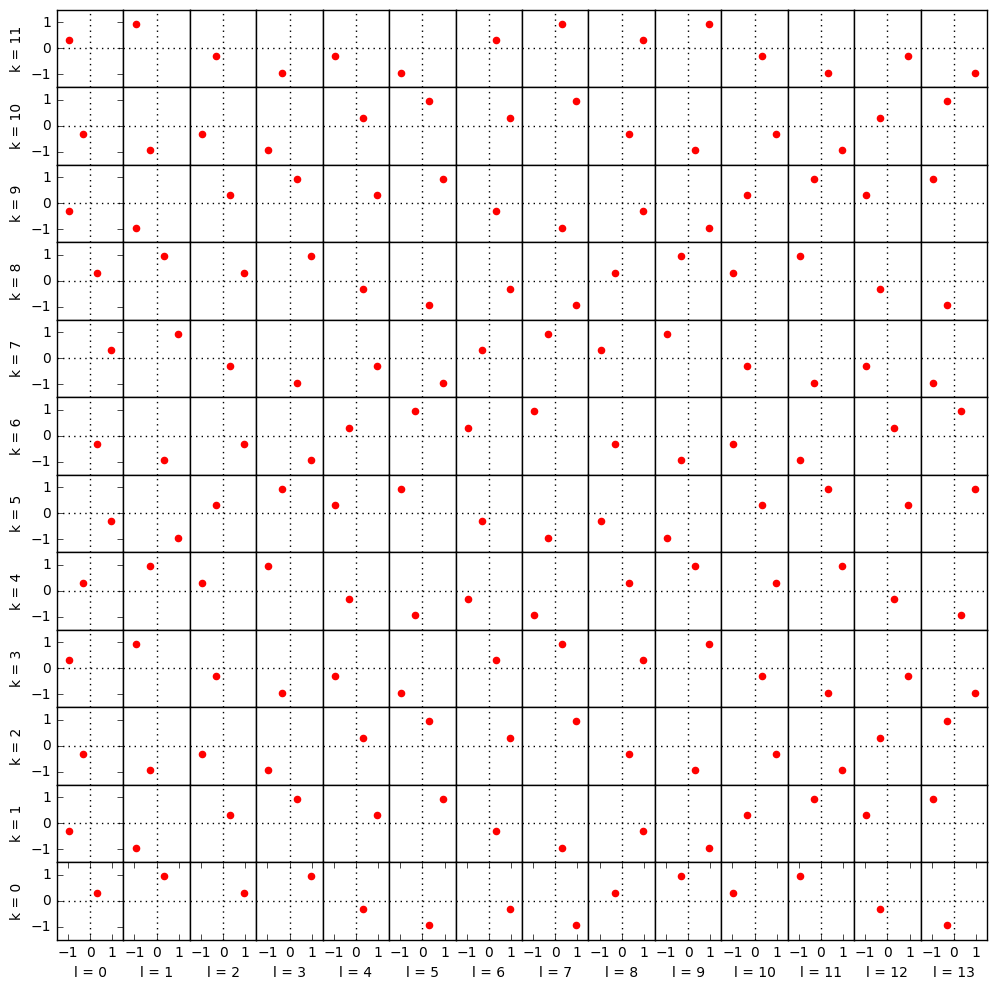

In [108]:
fig = plt.figure(figsize=(12, 12))
plt_complex_grid(a, fig)

In [52]:
def subc_time(k, p):
    t=np.linspace(0, 1e-3, p)
    n=np.zeros(p, dtype=np.complex_)
    l=0
    f = Df_ref*2**mu*(k-N_size_grid*N_SC_RB/2)
    for i in range(p):
        if l < len(t_start_l)-1 and t[i] > t_start_l[l+1]:
            l += 1    
        tc = T_c*N_cp(mu, l, ecp=False)+t_start_l[l]
        n[i] = a[k,l]*np.exp(1j*2*np.pi*f*(t[i]-tc))
    return t, n

In [53]:
def plot_subframe_c(t, n):
    plt.plot(t, np.real(n))
    plt.plot(t, np.imag(n))

    n_min = np.min([np.real(n), np.imag(n)])
    n_max = np.max([np.real(n), np.imag(n)])
    for l in range(len(t_start_l)):
        t = t_start_l[l]
        t_cp = t + N_cp(mu, l, ecp=False)*T_c
        plt.plot([t, t], [n_min, n_max], 'k--', lw=1)
        plt.plot([t_cp, t_cp], [n_min, n_max], 'k:', lw=1)

    axes = plt.gca()
    axes.set_xlim([0,1e-3])

In [60]:
def plot_subframe(p, fig):
    sb_r = N_size_grid*N_SC_RB
    sb_c = 1
    sb_id = 0
    for k in range(sb_r-1,-1,-1):
        grid = gridspec.GridSpec(sb_r, sb_c, wspace=0.0, hspace=0.0)
        t, n = subc_time(k, p)
        fig.add_subplot(grid[sb_id])
        plot_subframe_c(t, n)
        plt.ylabel('k = {}'.format(k))
        if k != 0:
            axes = plt.gca()
            axes.set_xticks([])
        sb_id += 1

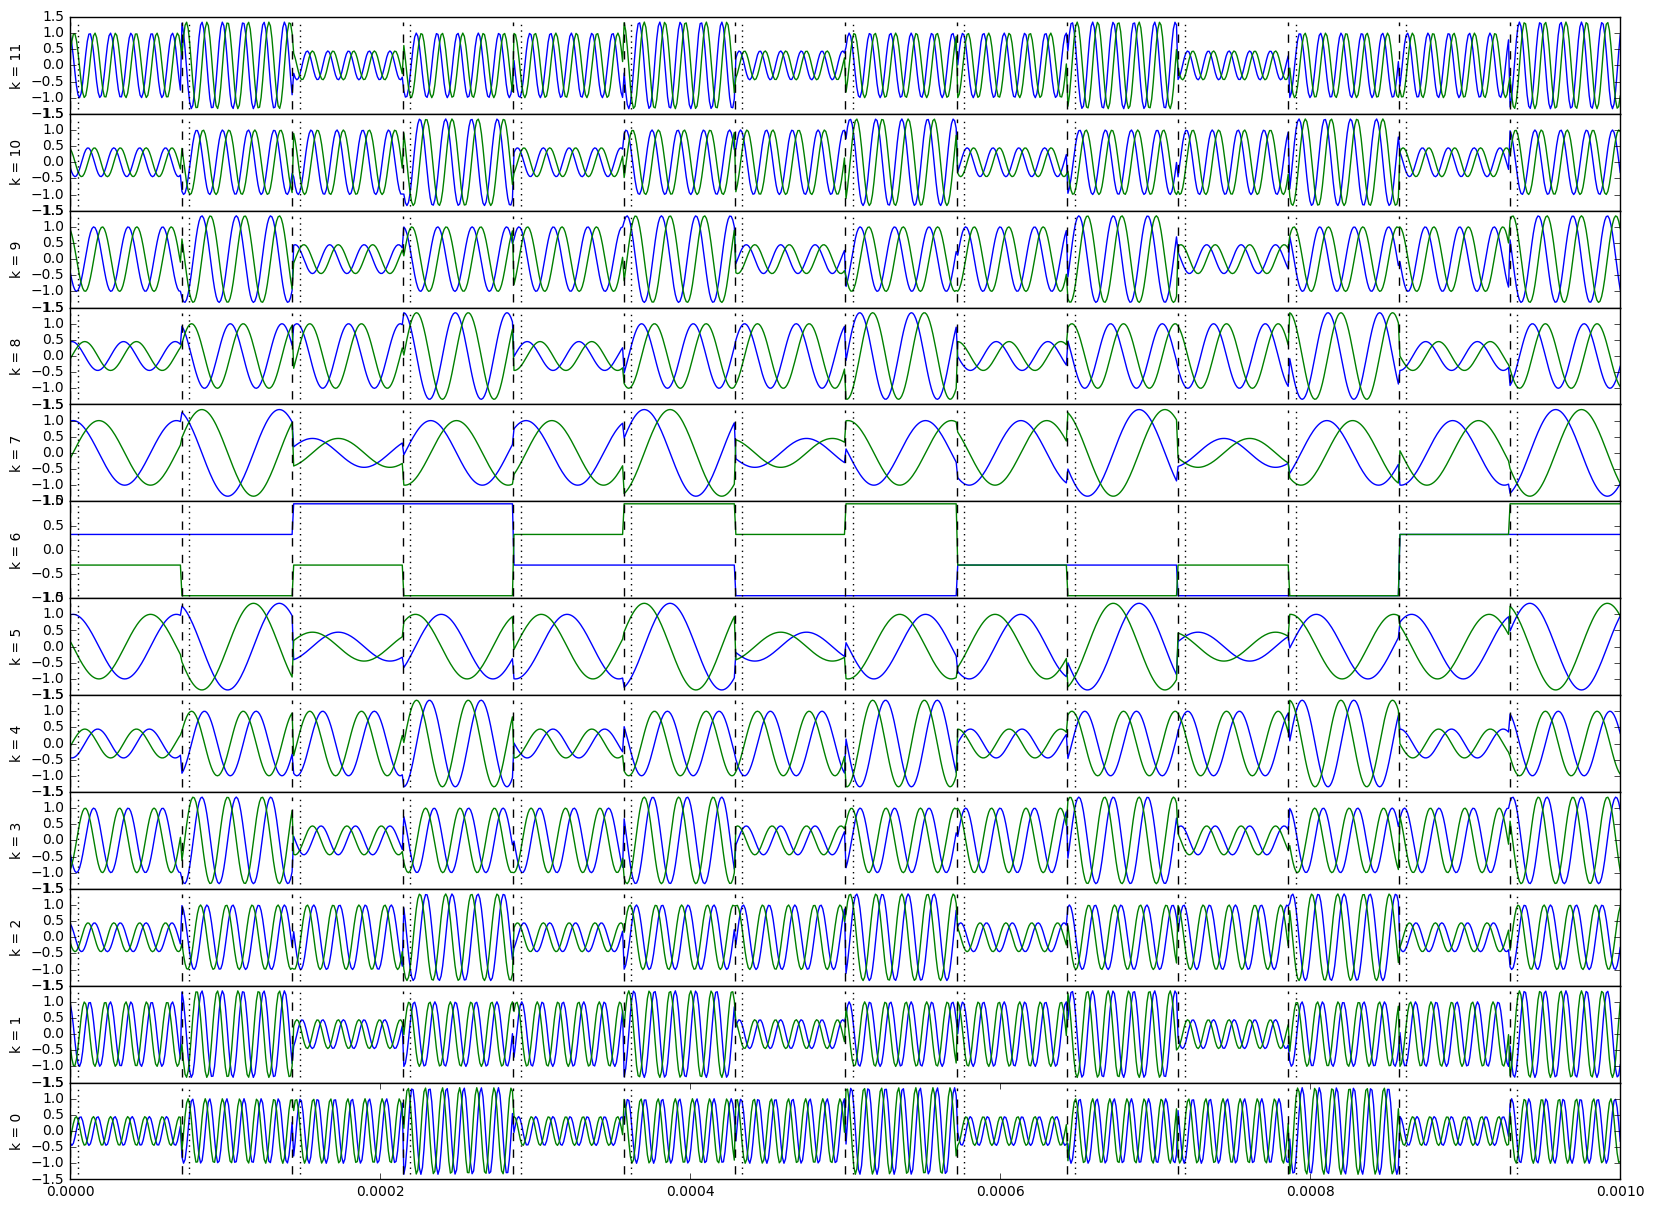

In [61]:
fig=plt.figure(figsize=(20, 15))
p=1000
plot_subframe(p, fig)

In [74]:
def subframe_time(p):
    s = np.zeros(p, dtype=np.complex_)
    for k in range(N_size_grid*N_SC_RB):
        t, n = subc_time(k, p)
        s += n
    return t, s

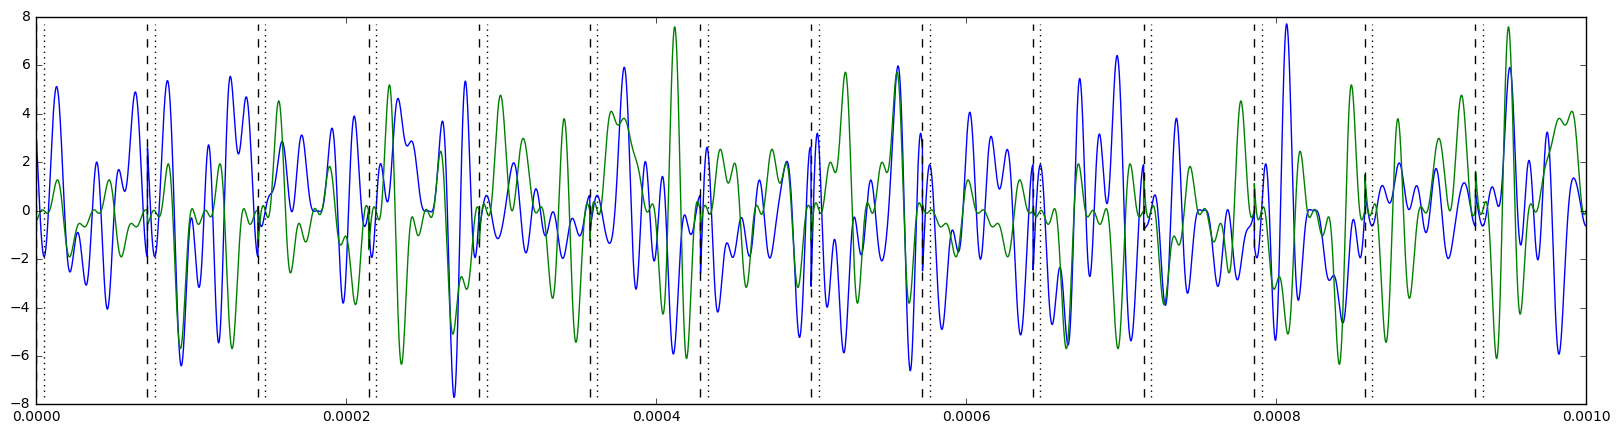

In [77]:
plt.figure(figsize=(20, 5))
p = 1024*14+72*12+80*2
t, s = subframe_time(p)
plot_subframe_c(t, s)

(-1.5, 1.5)

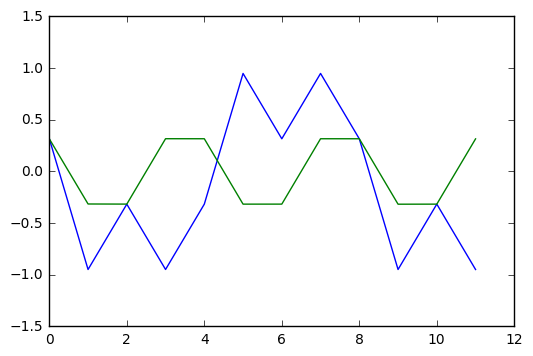

In [48]:
s_fft = np.fft.fft(s[80:1024+80])/1024
s_fft1 = np.concatenate((s_fft[1018:1024], s_fft[0:6]))
plt.plot(np.real(s_fft1))
plt.plot(np.imag(s_fft1))
axes = plt.gca()
axes.set_ylim([-1.5, 1.5])

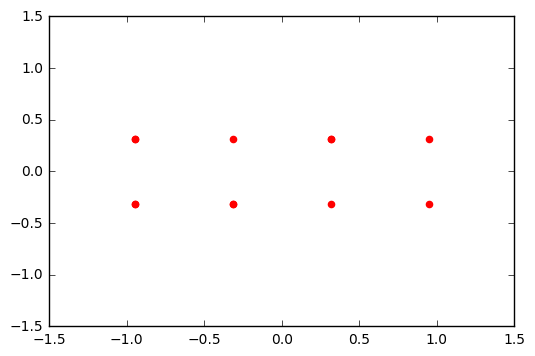

In [109]:
plt_complex(s_fft1)

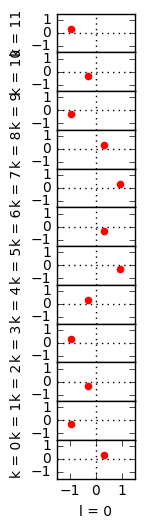

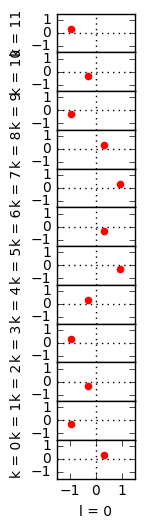

In [102]:
fft_c = np.zeros((12,1), dtype=np.complex_)
fft_c[:, 0] = np.transpose(s_fft1)

a_k0 = np.zeros((12,1), dtype=np.complex_)
a_k0[:, 0] = a[:,0]

fig=plt.figure(figsize=(1, 6))
plt_complex_grid(fft_c, fig)
fig=plt.figure(figsize=(1, 6))
plt_complex_grid(a_k0, fig)